In [2]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import spacy
import textstat
import language_tool_python
from spellchecker import SpellChecker
from sentence_transformers import SentenceTransformer, util
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.preprocessing import StandardScaler


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 📥 Load the dataset (downloaded from Kaggle)
file_path = "Dataset/ASAP2_train_sourcetexts.csv"  # Replace with your path
df = pd.read_csv(file_path, encoding='UTF-8')

### Feature Engineering

In [4]:
# Basic: Count
df['word_count'] = df['full_text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['full_text'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['full_text'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if pd.notnull(x) and len(str(x).split()) > 0 else 0
)

In [5]:
def categorize_score(score):
    if score <= 3:
        return 0
    else:
        return 1

df['score_class'] = df['score'].apply(categorize_score)

In [6]:

# Load tools
nlp = spacy.load("en_core_web_sm")
tool = language_tool_python.LanguageTool('en-US')
spell = SpellChecker()
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Define function to extract features from one essay
def extract_features(text):
    doc = nlp(text)
    
    # Readability & structure
    flesch = textstat.flesch_reading_ease(text)
    syllables = textstat.syllable_count(text)
    sentences = len(list(doc.sents))
    paragraphs = text.count("\n\n") + 1

    # Grammar & spelling
    grammar_errors = len(tool.check(text))
    misspelled = len(spell.unknown(text.split()))
    
    # Syntax
    pos_counts = doc.count_by(spacy.attrs.POS)
    noun_count = pos_counts.get(doc.vocab.strings["NOUN"], 0)
    verb_count = pos_counts.get(doc.vocab.strings["VERB"], 0)
    adj_count = pos_counts.get(doc.vocab.strings["ADJ"], 0)

    # Passive voice detection (simplified)
    passive = sum(1 for tok in doc if tok.dep_ == "nsubjpass")
    
    # Embeddings: intro vs. conclusion similarity
    sentences = [sent.text.strip() for sent in doc.sents if len(sent.text.strip().split()) > 3]
    if len(sentences) >= 2:
        intro = embedder.encode(sentences[0], convert_to_tensor=True)
        conclusion = embedder.encode(sentences[-1], convert_to_tensor=True)
        coherence = float(util.cos_sim(intro, conclusion)[0][0])
    else:
        coherence = 0.0

    return {
        "flesch_reading_ease": flesch,
        "syllable_count": syllables,
        "paragraph_count": paragraphs,
        "sentence_count": sentences,
        "grammar_errors": grammar_errors,
        "spelling_errors": misspelled,
        "noun_count": noun_count,
        "verb_count": verb_count,
        "adj_count": adj_count,
        "passive_voice_sentences": passive,
        "intro_conclusion_similarity": coherence
    }



In [7]:
import time

start = time.time()
extract_features(df['full_text'].iloc[0])
print("Time per essay:", time.time() - start)


Time per essay: 4.363277912139893


In [8]:
len(df)

24728

In [9]:
sample_df = df.sample(n=200, random_state=42)  
nlp_features_sample = sample_df['full_text'].apply(lambda x: extract_features(str(x)))


In [10]:
# Apply feature extraction to all essays (slow)
#nlp_features = df['full_text'].apply(lambda x: extract_features(str(x)))

# Merge into original DataFrame
nlp_features_sample = pd.DataFrame(list(nlp_features_sample))

# Ensure index alignment (important before concat)
nlp_features_sample.index = sample_df.index

final_df = pd.concat([sample_df, nlp_features_sample], axis=1)

In [11]:
# Use NLP features and other derived ones
feature_cols = [
    'word_count', 
    'char_count',
    'avg_word_length',
    "flesch_reading_ease",
    "syllable_count",
    "paragraph_count",
    "grammar_errors",
    "spelling_errors",
    "noun_count",
    "verb_count",
    "adj_count",
    "passive_voice_sentences",
    "intro_conclusion_similarity",
]



X = final_df[feature_cols]
y = final_df["score_class"] # We can also use "score" for regression tasks


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize for models that need scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


📘 Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        25
           1       0.90      0.60      0.72        15

    accuracy                           0.82        40
   macro avg       0.85      0.78      0.80        40
weighted avg       0.84      0.82      0.82        40



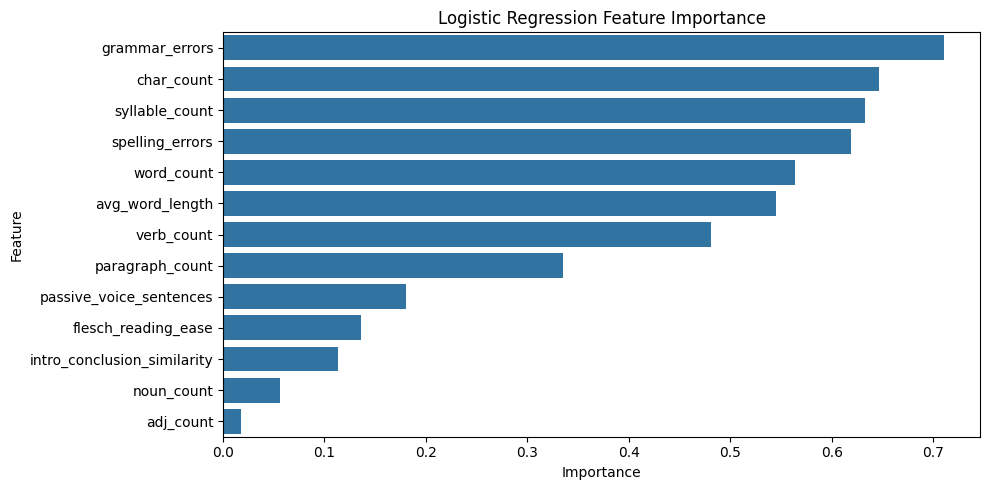

In [13]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("📘 Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_log))

# Feature importance
importance = np.mean(np.abs(log_reg.coef_), axis=0)
importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Logistic Regression Feature Importance")
plt.tight_layout()
plt.show()
